In [1]:
import warnings
warnings.filterwarnings("ignore")

from config import get_config
from train import train_model, grid_search

import torch
import inference_helpers

In [2]:
## TODO: dodelat pro n modelu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg = get_config()

## hyperparameter tuning
param_grid = {
        'max_depth': [8, 16, 24, 48],
        'reg_alpha': [0, 0.1, 0.2, 0.5, 1],
        'reg_lambda': [0, 0.1, 0.2, 0.5, 1],
    }
search_res = grid_search(cfg, device, lr_cv = 2.5*10**-1, n_cv = 20, param_grid = param_grid)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV 1/4] END max_depth=48, reg_alpha=0.1, reg_lambda=0;, score=-40551.879 total time=   0.9s
[CV 2/4] END max_depth=48, reg_alpha=0.1, reg_lambda=0;, score=-30336.994 total time=   1.1s
[CV 3/4] END max_depth=48, reg_alpha=0.1, reg_lambda=0;, score=-43048.180 total time=   1.3s
[CV 4/4] END max_depth=48, reg_alpha=0.1, reg_lambda=0;, score=-24812.641 total time=   1.9s
[CV 1/4] END max_depth=24, reg_alpha=0.5, reg_lambda=0.5;, score=-42788.445 total time=   0.2s
[CV 2/4] END max_depth=24, reg_alpha=0.5, reg_lambda=0.5;, score=-18307.447 total time=   0.6s
[CV 3/4] END max_depth=24, reg_alpha=0.5, reg_lambda=0.5;, score=-43162.523 total time=   1.0s
[CV 4/4] END max_depth=24, reg_alpha=0.5, reg_lambda=0.5;, score=-18562.102 total time=   1.5s
[CV 1/4] END max_depth=16, reg_alpha=0, reg_lambda=0;, score=-39263.613 total time=   0.2s
[CV 2/4] END max_depth=16, reg_alpha=0, reg_lambda=0;, score=-30578.297 total time=   0.6s
[CV 3

In [5]:
## Multiple model training
cfg = get_config()
num_models0 = 7
num_models1 = 8

for k in range(num_models0, num_models1+1):
    print(f"MODEL TRAINING - #{k}")
    print(20*"-")
    cfg = get_config()
    cfg['preload'] = None
    cfg['n_estimators'] = 120
    cfg["exo_vars"] = [
                "month_sin", "month_cos", "day_sin", "day_cos", "hour_sin", "hour_cos",
                "quarter_hour_sin", "quarter_hour_cos", "measured_&_upscaled_wind",
                "most_recent_forecast_wind", "total_load",
                "most_recent_forecast_load", "measured_&_upscaled_solar",
                "most_recent_forecast_solar", 'year', 'not_working', 'holiday',
    ]

    cfg["tgt_step"] = k-1
    cfg['run'] += f"Y_exact{k}"
    cfg['model_folder'] += cfg['run']
    cfg['experiment_name'] = f"runs{cfg['run']}/tmodel"

    model = train_model(cfg)
    print(20*"-")

MODEL TRAINING - #7
--------------------
Using device: cpu
[0]	validation_0-rmse:177.79751	validation_0-mae:130.97363	validation_1-rmse:169.22474	validation_1-mae:119.69428
[1]	validation_0-rmse:173.25771	validation_0-mae:127.84310	validation_1-rmse:168.11483	validation_1-mae:118.72437
[2]	validation_0-rmse:168.93378	validation_0-mae:124.87427	validation_1-rmse:167.42118	validation_1-mae:118.18555
[3]	validation_0-rmse:165.08099	validation_0-mae:122.24556	validation_1-rmse:166.54688	validation_1-mae:117.51344
[4]	validation_0-rmse:161.51105	validation_0-mae:119.83998	validation_1-rmse:166.05794	validation_1-mae:117.24280
[5]	validation_0-rmse:158.15390	validation_0-mae:117.55161	validation_1-rmse:165.59282	validation_1-mae:116.91386
[6]	validation_0-rmse:155.53534	validation_0-mae:115.77461	validation_1-rmse:165.28090	validation_1-mae:116.72814
[7]	validation_0-rmse:152.49899	validation_0-mae:113.69731	validation_1-rmse:164.71235	validation_1-mae:116.35972
[8]	validation_0-rmse:149.782

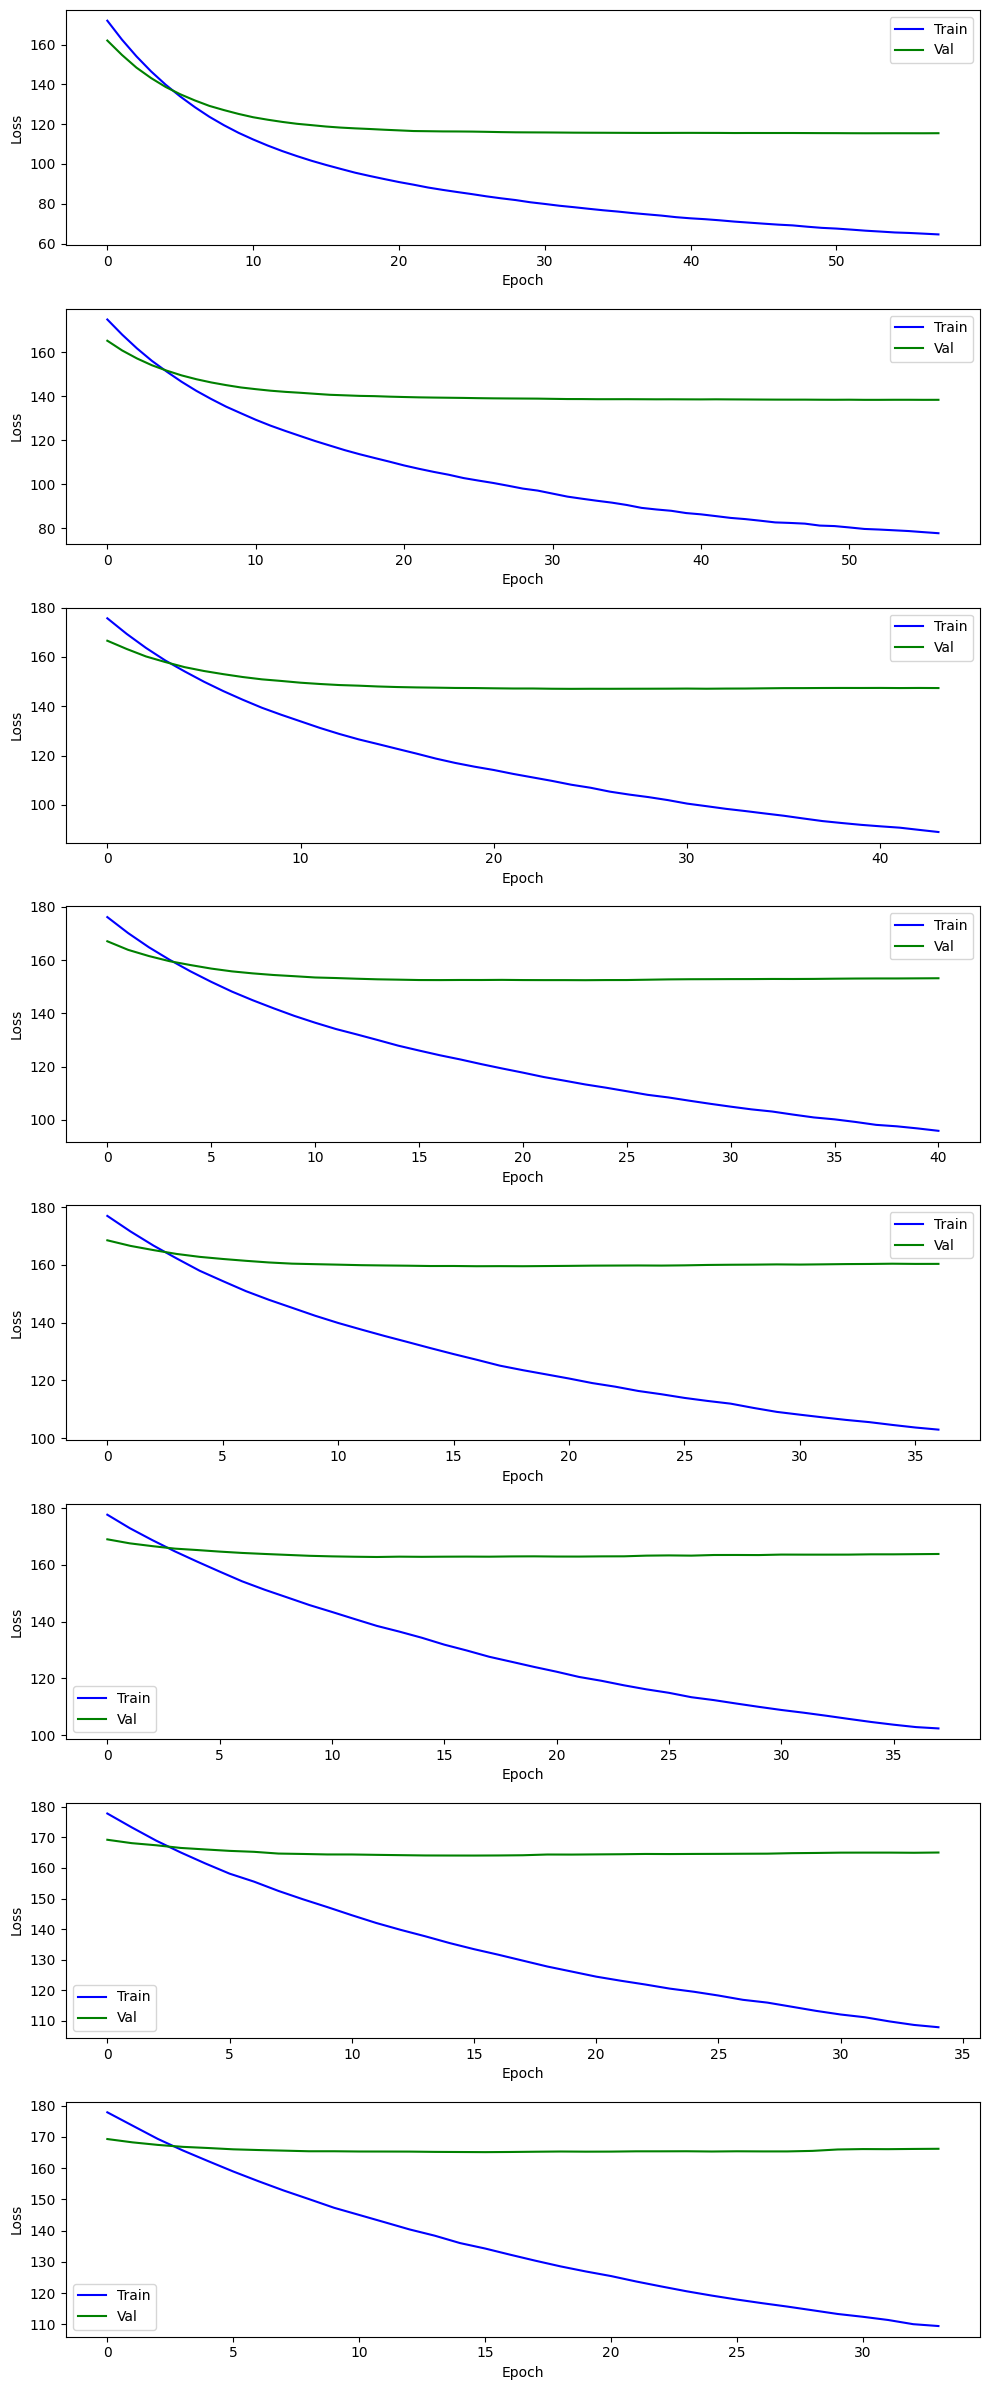

In [6]:
inference_helpers.arrange_figures_in_rows(n_rows=num_models1, prefix="XY_exact")

In [3]:
from train import get_ds
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [5]:
cfg = get_config()
cfg["tgt_step"] = 7
cfg["exo_vars"] = [
            "month_sin", "month_cos", "day_sin", "day_cos", "hour_sin", "hour_cos",
            "quarter_hour_sin", "quarter_hour_cos", "measured_&_upscaled_wind",
            "most_recent_forecast_wind", "total_load",
            "most_recent_forecast_load", "measured_&_upscaled_solar",
            "most_recent_forecast_solar", 'year', 'not_working', 'holiday',
]
x_train, y_train, x_test, y_test, train_ds, val_ds = get_ds(cfg)

In [110]:
mean_absolute_error(model.predict(x_test, iteration_range=(0,9)), y_test.squeeze())

117.03606

In [101]:
mean_squared_error(model.predict(x_test, iteration_range=(0,3)), y_test.squeeze(), squared=False)

168.392

In [ ]:
# pozorovani
# -- xgboost vyuziva vsechny stromy k predikci, dohormady davaji nejlepsi
# prediktor az do k-te vrstvy
# -- posledni z eval_metrics se pouziva k early_stopping, takze je treba je usporadat
# -- validacni sada bude potreba k treninku, tudiz musim sehnat i testovaci sadu
# ? mozna bych mohl dostahovat aktualni data